# Example usage of NRSur3dq8_RD fit.

In [2]:
# Silence an annoying lal warning
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [3]:
import surfinBH

In [4]:
fit_name = 'NRSur3dq8_RD'

## Load the fit, this only needs to be done once at the start of a script

In [5]:
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8_RD fit.


## Read the documentation

In [5]:
help(fit)

Help on Fit3dq8_RD in module surfinBH._fit_evaluators.fit_3dq8_RD object:

class Fit3dq8_RD(surfinBH.surfinBH.SurFinBH)
 |  Fit3dq8_RD(name)
 |  
 |  A class for the NRSur3dq8_RD model presented in Magana Zertuche et al.,
 |  arxiv:TODO.
 |  
 |  This model predicts the final mass mf, final spin chif, and
 |  complex QNM amplitudes A_(l,m,n,p), for the remnants of
 |  nonprecessing binary black hole systems. The fits are done using
 |  Gaussian Process Regression (GPR) and also provide an error
 |  estimate along with the fit value.
 |  
 |  This model has been trained in the parameter space:
 |      q <= 8, |chiAz| <= 0.8, |chiBz| <= 0.8
 |  
 |  However, it extrapolates reasonably to:
 |      q <= 10, |chiAz| <= 1, |chiBz| <= 1
 |  
 |  =========================================================================
 |  Usage:
 |  
 |  import surfinBH
 |  
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur3dq8_RD')
 |  
 |  We provide the following call methods:
 |      # remnant mass an

## Evaluate the fits

In [6]:
q = 4.3             # Mass ratio q>=1
chiA = [0,0,0.6]    # Spin of larger BH (z-direction only)
chiB = [0,0,-0.7]   # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

# remnant mass and 1-sigma error estimate
mf, mf_err = fit.mf(q, chiA, chiB)

# remnant spin and 1-sigma error estimate
chif, chif_err = fit.chif(q, chiA, chiB)

# remnant mass, spin, and all available modes
mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB)
print(QNM_dict.keys())
QNM_dict[(2,2,0,1)]

dict_keys([(2, 2, 0, 1), (2, -2, 0, -1), (2, 2, 1, 1), (2, -2, 1, -1), (2, 0, 0, 1), (2, 0, 0, -1), (4, 4, 0, 1), (4, -4, 0, -1), (3, 2, 0, 1), (3, -2, 0, -1)])


(0.12748926488933388+0.02625691939794353j)

In [7]:
# Only request a subset of modes
modes=[ (2, 2, 0, 1), (2, -2, 0, -1), (2, 0, 0, 1), (2, 0, 0, -1) ]
mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB, modes=modes)
print(QNM_dict.keys())

dict_keys([(2, 2, 0, 1), (2, -2, 0, -1), (2, 0, 0, 1), (2, 0, 0, -1)])


## Reconstruct superrest frame waveform from some modes (requires `qnm` package)

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
import qnm

In [ ]:
qnm.download_data() # Only need to do this once

In [8]:
from example_utils import qnm_from_tuple

In [11]:
?qnm_from_tuple

Signature: qnm_from_tuple(tup, chi, M, s=-2)
Docstring:
Get frequency and spherical-spheroidal mixing from qnm package

Parameters
----------
tup : tuple 
    Index (ell,m,n,sign) of QNM

chi : float
    The dimensionless spin of the black hole, 0. <= chi < 1.

M : float
    The mass of the remnant black hole, M > 0.

s : int, optional [Default: -2]

Returns
-------
omega: complex
    Frequency of QNM, in units of inverse initial total mass M

C: complex ndarray
    Spherical-spheroidal decomposition coefficient array

ells: ndarray 
    List of ell values for the spherical-spheroidal mixing array
File:      /central/home/leo/src/surfinBH/examples/example_utils.py
Type:      function

In [12]:
q = 4.3             # Mass ratio q>=1
chiA = [0,0,0.6]    # Spin of larger BH (z-direction only)
chiB = [0,0,-0.7]   # Spin of smaller BH (z-direction only)

mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB)

###

# All times in units of initial M
t     = np.arange(0., 100., 0.05)
t_0   = 20.
t_ref = 20.

h_mode_labels = [(l,m) for l in [2,3,4] for m in np.arange(-l, l+1)]

h = {}
for (ell_prime, m_prime, n, sign), A in QNM_dict.items():
    omega, C, ells = qnm_from_tuple((ell_prime, m_prime, n, sign), 
                                     chif, mf)

    expiwt = np.exp( -1.j * omega * (t - t_ref))
    expiwt[ t < t_0 ] = 0.
    for h_l, h_m in h_mode_labels:
        if (h_m == m_prime):
            c_l = C[ells == h_l]
            if (len(c_l) > 0):
                c_l = c_l[0]
                h[(h_l, h_m)] = c_l * A * expiwt + h.get((h_l, h_m), 0.)

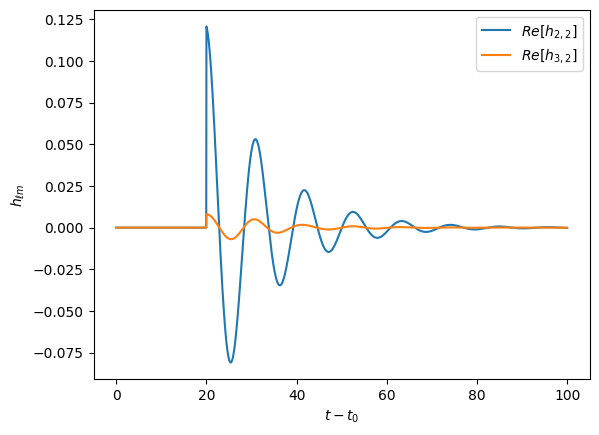

In [15]:
# Spherical (3,2) mode contains contributions from (3,2,0,1) QNM and mixing from (2,2,0,1) QNM
plt.plot(t, h[(2,2)].real, label='$Re[h_{2,2}]$')
plt.plot(t, h[(3,2)].real, label='$Re[h_{3,2}]$')
plt.xlabel('$t-t_0$')
plt.ylabel('$h_{\\ell m}$')
plt.legend()
plt.show()
Notebook


## Reproduce Figure 10 from the paper

Here we reproduce the paper's figure 10.

Note that we use the publicly available surrogoate model as a proxy for the NR data in this notebook. This is different from the NR data used in the paper, which was computed using cauchy characteristic evolution in the superrest frame. 

This part of the notebook requires GWSurrogate

In [9]:
import gwsurrogate as gws
from gwtools import minimize_norm_error_multi_mode

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [10]:
sur = gws.LoadSurrogate('NRHybSur3dq8')

Loaded NRHybSur3dq8 model


In [11]:
def ringdown(q, chiA, chiB, t):

    t_0   = 20.
    t_ref = 20.
    
    mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB)
    
    h_mode_labels = [(l,m) for l in [2,3,4] for m in np.arange(-l, l+1)]
    
    h = {}
    
    for (ell_prime, m_prime, n, sign), A in QNM_dict.items():
        omega, C, ells = qnm_from_tuple((ell_prime, m_prime, n, sign), chif, mf)

        expiwt = np.exp( -1.j * omega * (t - t_ref))
        expiwt[ t < t_0 ] = 0.
        for h_l, h_m in h_mode_labels:
            if (h_m == m_prime):
                c_l = C[ells == h_l]
                if (len(c_l) > 0):
                    c_l = c_l[0]
                    h[(h_l, h_m)] = c_l * A * expiwt + h.get((h_l, h_m), 0.)

    return h

In [43]:
q = 4.1
chiA = [0, 0, -0.3]
chiB = [0, 0, -0.8]
f_low = 5e-3    # initial frequency, Units of cycles/M

t     = np.arange(0., 100., 0.05)
t, hnr, dyn = sur(q, chiA, chiB,  f_low=f_low, times=t)  
h_RD = ringdown(q, chiA, chiB, t) 

common_modes = set(hnr.keys()).intersection( set(h_RD.keys()) )

hnr = {mode: hnr[mode] for mode in common_modes}
h_RD = {mode: h_RD[mode] for mode in common_modes}

# find optimal time and phase shift to match h_RD to hnr
[errors_before_min, errors_after_min], [tc, phic], [common_times,hnr_aligned,h_RD_aligned] = \
                            minimize_norm_error_multi_mode(t, hnr, t, h_RD, mode_list=None, ell_m_match=(2,2),\
                                    t_low_adj=0,t_up_adj=0,method='nelder-mead')

mode_differences = {}
for mode in common_modes:
    mode_differences[mode] = abs(hnr_aligned[mode] - h_RD_aligned[mode])

(0.0, 100.0)

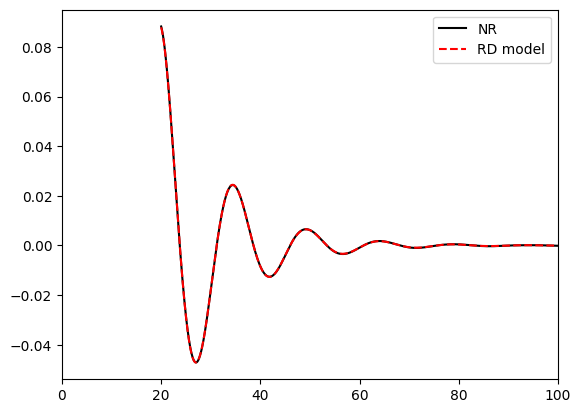

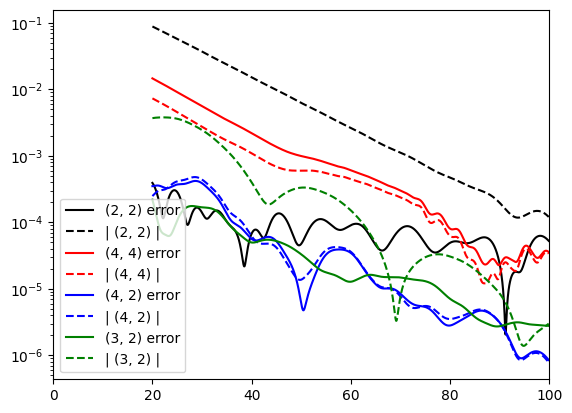

In [62]:
plt.figure(1)
plt.plot(common_times,hnr_aligned[(2,2)].real,'k', label='NR')
plt.plot(common_times,h_RD_aligned[(2,2)].real,'r--', label='RD model')
plt.legend()
plt.xlim([0,100])

plt.figure(2)
mode = (2,2)
plt.semilogy(common_times,mode_differences[mode], 'k', label='{} error'.format(mode))
plt.semilogy(common_times, np.abs(hnr_aligned[mode]), 'k--', label='| {} | '.format(mode))
mode = (4,4)
plt.semilogy(common_times,mode_differences[mode], 'r', label='{} error'.format(mode))
plt.semilogy(common_times, np.abs(hnr_aligned[mode]), 'r--', label='| {} | '.format(mode))
mode = (4,2)
plt.semilogy(common_times,mode_differences[mode], 'b', label='{} error'.format(mode))
plt.semilogy(common_times, np.abs(hnr_aligned[mode]), 'b--', label='| {} | '.format(mode))
mode = (3,2)
plt.semilogy(common_times,mode_differences[mode], 'g', label='{} error'.format(mode))
plt.semilogy(common_times, np.abs(hnr_aligned[mode]), 'g--', label='| {} | '.format(mode))
plt.legend()
plt.xlim([0,100])